 # Preparetion of an observatory filler catalog for PFS enginnering run in May 2024

 Author: Masato Onodera



 ## Introduction

 This notebook describes the procedure to select targets for the PFS engineering run in May 2024. The targets are prepared as the observatory filler category. The observatory filler is the lowest priority category which do not affect the pointing optimization, and will be observed when there are no other targets to observe with higher priorities.



 Observatory filler needs to distribute uniformly over the sky, and should be bright enough to be observed in a unit exposure time of 900s. In this notebook, we use the Pan-STARRS1 (PS1) Data Release 2 (DR2) catalog to select targets. As a test case we will select objects in the ELAIS-N1 field which will be targeted in the enginnering run.

 ## Prerequisites

 - You need an account on the MAST CasJobs (https://mastweb.stsci.edu/ps1casjobs/MyDB.aspx) to query the PS1 DR2 database.

 - A python (>=3.9?) environment with the following packages: astropy, pandas, numpy, matplotlib, pyarrow, and seaborn

 ## Initial Selection on the MAST database server



 The initial selection criteria are as follows:

 - More than 1 detections in i-band in different epochs.

 - Forced-Mean Kron AB magnitude in i-band equal or brighter than 22. The exact faint limit will be determined by looking at the sky density. In this work, we eventually set the faint limit to 21.75.

 - S/N > 3 in i-band Kron flux in the Forced-Mean photometry.

 - GOOD photometry flag is true (`QF_OBJ_GOOD=4` flag is active; https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Flags).

 - Circular area with 2.5 degree radius centered at (RA, Dec) = (242.75, 55.0) deg.



 The selection is done with the following SQL query on the PS1 DR2 database with `PanSTARRS_DR2` context:



 ```sql

 SELECT o.objID,

    o.raMean, o.decMean, o.raMeanErr, o.decMeanErr,

    o.raStack, o.decStack, o.raStackErr, o.decStackErr,

    o.epochMean,

    o.nDetections as nDetectionsMean,

    o.ng, o.nr, o.ni, o.nz, o.ny,

    o.objInfoFlag, o.astrometryCorrectionFlag, o.qualityFlag,

    m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag,

    m.gMeanPSFMagErr, m.rMeanPSFMagErr, m.iMeanPSFMagErr, m.zMeanPSFMagErr, m.yMeanPSFMagErr,

    m.gMeanKronMag, m.rMeanKronMag, m.iMeanKronMag, m.zMeanKronMag, m.yMeanKronMag,

    m.gMeanKronMagErr, m.rMeanKronMagErr, m.iMeanKronMagErr, m.zMeanKronMagErr, m.yMeanKronMagErr,

    m.gFlags as gFlagsMean, m.rFlags as rFlagsMean, m.iFlags as iFlagsMean, m.zFlags as zFlagsMean, m.yFlags as yFlagsMean,

    fmo.nDetections as nDetectionsForced,

    fmo.gnTotal, fmo.rnTotal, fmo.inTotal, fmo.znTotal, fmo.ynTotal,

    fmo.gFPSFFlux, fmo.rFPSFFlux, fmo.iFPSFFlux, fmo.zFPSFFlux, fmo.yFPSFFlux,

    fmo.gFPSFFluxErr, fmo.rFPSFFluxErr, fmo.iFPSFFluxErr, fmo.zFPSFFluxErr, fmo.yFPSFFluxErr,

    fmo.gFPSFMag, fmo.rFPSFMag, fmo.iFPSFMag, fmo.zFPSFMag, fmo.yFPSFMag,

    fmo.gFPSFMagErr, fmo.rFPSFMagErr, fmo.iFPSFMagErr, fmo.zFPSFMagErr, fmo.yFPSFMagErr,

    fmo.gFKronFlux, fmo.rFKronFlux, fmo.iFKronFlux, fmo.zFKronFlux, fmo.yFKronFlux,

    fmo.gFKronFluxErr, fmo.rFKronFluxErr, fmo.iFKronFluxErr, fmo.zFKronFluxErr, fmo.yFKronFluxErr,

    fmo.gFKronMag, fmo.rFKronMag, fmo.iFKronMag, fmo.zFKronMag, fmo.yFKronMag,

    fmo.gFKronMagErr, fmo.rFKronMagErr, fmo.iFKronMagErr, fmo.zFKronMagErr, fmo.yFKronMagErr,

    fmo.gFlags as gFlagsForced, fmo.rFlags as rFlagsForced, fmo.iFlags as iFlagsForced, fmo.zFlags as zFlagsForced, fmo.yFlags as yFlagsForced

 INTO mydb.ps1dr2_idet1_i18_22

 FROM fGetNearbyObjEq(242.75, 55.0, 150) nb

    INNER JOIN ObjectThin o ON o.objID = nb.objID

    -- require at least 2 detections in i-band

    AND ni > 1

    INNER JOIN MeanObject m ON o.objid = m.objid

    AND o.uniquePspsOBid = m.uniquePspsOBid

    INNER JOIN ForcedMeanObject fmo ON o.objID = fmo.objID

    AND fmo.iFKronMag >= 18.0 AND fmo.iFKronMag <= 22.0;

 ```



 The results can be seen as the `ps1dr2_ide1_i18_22` table in the `MyDB` section of the MAST CasJobs. You can download it as a FITS binary table file (e.g., `ps1dr2_ide1_i18_22_monodera.fit`).



 ### (optional but useful) Match objects with the PS1 DR1 Point Source Catalog



 To separate stars and galaxies, we can use the [PS1 DR1 Point Source Catalog (PSC)](https://archive.stsci.edu/prepds/ps1-psc/) which provides a point source score. The PSC catalog is based on DR1, but the objID is defined by the coordinates (https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Identifiers), so matching for the primary object would work fine for DR2. Note that the positional difference between DR1 and DR2 is order of 0.1-0.2 arcsec for most of the objects (see a diagnostic plot below). The following SQL query can be used to match the objects with the PSC catalog:



 ```sql

 SELECT mydata.*,

    psc.ps_score,

    psc.raMean as raMeanPSC, psc.decMean as decMeanPSC,

    psc.raStack as raStackPSC, psc.decStack as decStackPSC,

    psc.iKronMag as iKronMagPSC, psc.iKronMagErr as iKronMagErrPSC

 INTO mydb.ps1dr2_idet1_i18_22_psc

 FROM mydb.ps1dr2_idet1_i18_22 mydata

    LEFT JOIN HLSP_PS1_PSC.pointsource_magnitudes_view psc ON mydata.objID = psc.objID

    AND psc.primaryDetection = 1;

 ```



 Note that two queries above can be combined, but takes a long time to run. Also, select the HLSP_PS1_PSC context to run the query.



 Following the classification paper (Tachine & Miller 2018), a threshold of `ps_score=0.83` will be used in our selection.



 Please download the table as a FITS binary table file (e.g., `ps1dr2_idet1_i18_22_psc_monodera.fit`).



 ### Reference web sites



 - [Pan-STARRS1 DR2](https://panstarrs.stsci.edu/)

 - [MAST Query / CasJobs](https://mastweb.stsci.edu/ps1casjobs/default.aspx)

 - [PS1 ObjectThin table](https://outerspace.stsci.edu/display/PANSTARRS/PS1+ObjectThin+table+fields)

 - [PS1 ForcedMeanObject table](https://outerspace.stsci.edu/display/PANSTARRS/PS1+ForcedMeanObject+table+fields)

 - [PS1 Object Flags](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Flags)

 - [PS1 Object Identifiers](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Identifiers)

 - [PS1 Sample queries](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Sample+Queries)

 - [PS1 Point Source Catalog](https://archive.stsci.edu/prepds/ps1-psc/)

 - [PS1 How to separate stars and galaxies](https://outerspace.stsci.edu/display/PANSTARRS/How+to+separate+stars+and+galaxies)

 - [PS1 FAQ on star/galaxy separation](https://outerspace.stsci.edu/display/PANSTARRS/PS1+FAQ+-+Frequently+asked+questions#PS1FAQFrequentlyaskedquestions-HowcanIdistinguishstarsfromgalaxiesinthecatalog?)

 - [Kokubo-san's tutorial](https://www.kwasan.kyoto-u.ac.jp/~yamanaka/mw/DataAnalysis2020_Kokubo.pdf) (in Japanese)





 ## Target selection in the local environment



 ### import necessary packages

In [37]:
# %%
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.visualization.wcsaxes import SphericalCircle, WCSAxes


 ### Load the catalog and clean up the data

In [38]:
# %%
# Load the catalog

# define input file
infile = "ps1dr2_idet1_i18_22_psc_monodera.fit"


# read the FITS binary table as astorpy.Table
tb_orig = Table.read(infile, format="fits")

# convert to pandas.DataFrame after fixing the shape ((nobj, 1) to (nobj)) of each column in the table
tb_fixed = Table()
for c in tb_orig.colnames:
    tb_fixed[c] = tb_orig[c][:, 0]
df = tb_fixed.to_pandas()


In [39]:
# %%
# fill the -999 values with np.nan in the flux and mag columns
bands = ["g", "r", "i", "z", "y"]
fluxkeys = ["FPSFFlux", "FPSFMag", "FKronFlux", "FKronMag", "MeanPSFMag", "MeanKronMag"]
for band in bands:
    for keys in fluxkeys:
        df.loc[df[f"{band}{keys}"] == -999, f"{band}{keys}"] = np.nan
        df.loc[df[f"{band}{keys}Err"] == -999, f"{band}{keys}Err"] = np.nan


In [40]:
# %%
# fill the -999 values with np.nan in the ra and dec columns
# in principle, these shouldn't happen for good detections
for key in ["raMean", "decMean", "raStack", "decStack"]:
    df.loc[df[key] == -999, key] = np.nan




 ### Further selection of objects and add star/galaxy classification

In [41]:
# %%
# ps_score threshold of 0.83 is used for star/galaxy separation
ps_score_threshold = 0.83

# define the faint magnitude limit
faint_mag_threshold = 21.75

# define selectiìon criteria
idx_all = (
    # Forced-Mean Kron AB magnitude in i-band equal or brighter than 22
    (df["iFKronMag"] <= faint_mag_threshold)
    # GOOD photometry flag
    & (np.bitwise_and(df["qualityFlag"], 4).astype(bool))
    # S/N > 3 in i-band flux
    & (df["iFKronFlux"] / df["iFKronFluxErr"] > 3)
)

# separate galaxies and stars, as well as objects with no PSC score
idx_galaxy = np.logical_and(idx_all, df["ps_score"] < ps_score_threshold)
idx_star = np.logical_and(idx_all, df["ps_score"] >= ps_score_threshold)
idx_no_psc = np.logical_and(idx_all, df["ps_score"].isna())

# create a new DataFrames for the selections
df_select = df.loc[idx_all, :]
df_galaxy = df.loc[idx_galaxy, :]
df_star = df.loc[idx_star, :]
df_no_psc = df.loc[idx_no_psc, :]

print(f"Selection: {df.index.size} --> {df_select.index.size}")
print(f"Number of stars: {df_star.index.size}")
print(f"Number of galaxies: {df_galaxy.index.size}")
print(f"Number of objects with no PSC score: {df_no_psc.index.size}")

# area to be searched for this selection (i.e., circular area with 150 arcmin radius)
area = np.pi * (150 * u.arcmin) ** 2

# compute number density of objects
print(
    f"Number density of objects: {df_select.index.size / (area.to(u.arcmin**2).value):.2f} arcmin^-2"
)


Selection: 310246 --> 272849
Number of stars: 83889
Number of galaxies: 185803
Number of objects with no PSC score: 3157
Number density of objects: 3.86 arcmin^-2


 ### Save the selected objects in a file

In [42]:
# %%
# save the original (cleaned) tables in parquet format
df.to_parquet(f"{os.path.splitext(infile)[0]}.parquet")

# reset index of the selected objects and save it in parquet format
df_select.reset_index(drop=True, inplace=True)
df_select.to_parquet(f"{os.path.splitext(infile)[0]}_select.parquet")




 ## Diagnostic plots

 ### Sky distribution of objects

In [43]:
# %%
# define HSC-SSP pointings
coords_hsc = [
    SkyCoord("16 11 00.81 +53 56 30.71", frame="icrs", unit=(u.hourangle, u.deg)),
    SkyCoord("16 15 46.66 +54 59 17.74", frame="icrs", unit=(u.hourangle, u.deg)),
    SkyCoord("16 10 54.07 +56 02 49.65", frame="icrs", unit=(u.hourangle, u.deg)),
    SkyCoord("16 06 16.19 +54 59 16.91", frame="icrs", unit=(u.hourangle, u.deg)),
]

# define objects' coordinates
c_obj = SkyCoord(
    ra=df_select["raStack"].to_numpy() * u.deg,
    dec=df_select["decStack"].to_numpy() * u.deg,
    frame="icrs",
)


In [44]:
# %%
# count the number of objects with in the HSC coverage
in_c = 0
is_sep_any = np.full(c_obj.size, False, dtype=bool)
for c in coords_hsc:
    sep = c_obj.separation(c)
    is_sep = sep < 0.75 * u.deg
    is_sep_any = np.logical_or(is_sep_any, is_sep)
    # print(np.sum(sep < 0.75 * u.deg))
    in_c += np.sum(sep < 0.75 * u.deg)
# print(in_c)
print(f"N(HSC) = {np.sum(is_sep_any)}")



N(HSC) = 92222


In [45]:
# %%
# create a sort of a dummy wcs object to make a plot
w = wcs.WCS(naxis=2)
w.wcs.crpix = [0, 0]
w.wcs.cdelt = [-1.0, 1.0]
w.wcs.crval = [242.75, 55.0]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]



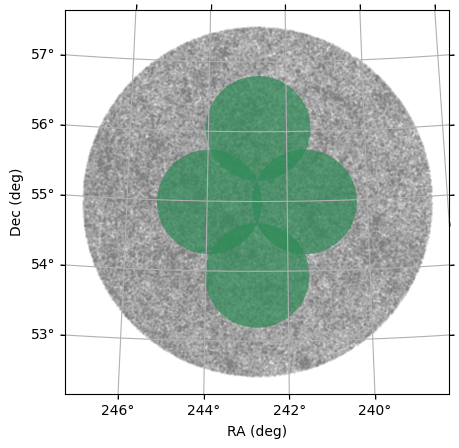

In [46]:
# %%
# plot sky distribution of objects
fig = plt.figure()
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=w, aspect="equal")
fig.add_axes(ax)
ax.scatter(
    df_select["raStack"],
    df_select["decStack"],
    s=1,
    c="gray",
    alpha=0.05,
    rasterized=True,
    transform=ax.get_transform("icrs"),
)
for c in coords_hsc:
    spherical_circle = SphericalCircle(
        c,
        0.75 * u.deg,
        edgecolor="none",
        facecolor="seagreen",
        transform=ax.get_transform("icrs"),
        alpha=0.7,
    )
    ax.add_patch(spherical_circle)
ax.grid()
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")

x_ra = ax.coords[0]
y_dec = ax.coords[1]

x_ra.set_major_formatter("d")

plt.savefig("sky_dist.png", dpi=300, bbox_inches="tight")
plt.show()


 ### Cumulative number density of objects

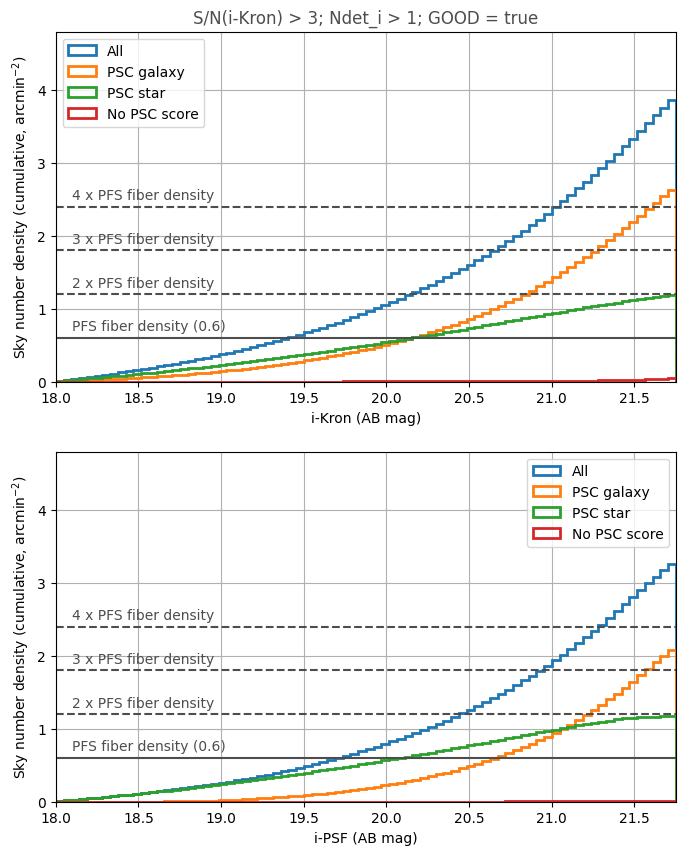

In [47]:
# %%
# plot cumulative number density of objects
# number density is normalized by the search area
norm_factor = 1 / area.to(u.arcmin**2).value  # nomarlization factor to arcmin^-2
pfs_fd = 0.6  # PFS fiber density in arcmin^-2
fd_textpos = 18.1
fd_textoffset = 0.1
xmin, xmax = 18, faint_mag_threshold

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# for i-Kron magnitude
df_select["iFKronMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_select.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[0],
    label="All",
    color="C0",
)
df_galaxy["iFKronMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_galaxy.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[0],
    label="PSC galaxy",
    color="C1",
)
df_star["iFKronMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_star.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[0],
    label="PSC star",
    color="C2",
)
df_no_psc["iFKronMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_no_psc.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[0],
    label="No PSC score",
    color="C3",
)

# draw lines for PFS fiber density
ax[0].axhline(pfs_fd, color="0.3", linestyle="solid")
ax[0].axhline(pfs_fd * 2, color="0.3", linestyle="dashed")
ax[0].axhline(pfs_fd * 3, color="0.3", linestyle="dashed")
ax[0].axhline(pfs_fd * 4, color="0.3", linestyle="dashed")
ax[0].text(fd_textpos, pfs_fd + fd_textoffset, "PFS fiber density (0.6)", color="0.3")
ax[0].text(fd_textpos, pfs_fd * 2 + fd_textoffset, "2 x PFS fiber density", color="0.3")
ax[0].text(fd_textpos, pfs_fd * 3 + fd_textoffset, "3 x PFS fiber density", color="0.3")
ax[0].text(fd_textpos, pfs_fd * 4 + fd_textoffset, "4 x PFS fiber density", color="0.3")
ax[0].legend()
ax[0].set_title("S/N(i-Kron) > 3; Ndet_i > 1; GOOD = true", color="0.3")
ax[0].set_xlabel("i-Kron (AB mag)")
ax[0].set_ylabel("Sky number density (cumulative, arcmin$^{-2}$)")
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(0, 4.8)

# for i-PSF magnitude
df_select.loc[np.isfinite(df_select["iFPSFMag"]), "iFPSFMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(np.isfinite(df_select["iFPSFMag"]).sum(), norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[1],
    label="All",
    color="C0",
)
df_galaxy["iFPSFMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_galaxy.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[1],
    label="PSC galaxy",
    color="C1",
)
df_star["iFPSFMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(df_star.index.size, norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[1],
    label="PSC star",
    color="C2",
)
df_no_psc.loc[np.isfinite(df_no_psc["iFPSFMag"]), "iFPSFMag"].hist(
    cumulative=True,
    density=False,
    weights=np.full(np.isfinite(df_no_psc["iFPSFMag"]).sum(), norm_factor),
    bins=80,
    histtype="step",
    linewidth=2,
    range=(xmin, xmax),
    ax=ax[1],
    label="No PSC score",
    color="C3",
)

# draw lines for PFS fiber density
ax[1].axhline(pfs_fd, color="0.3", linestyle="solid")
ax[1].axhline(pfs_fd * 2, color="0.3", linestyle="dashed")
ax[1].axhline(pfs_fd * 3, color="0.3", linestyle="dashed")
ax[1].axhline(pfs_fd * 4, color="0.3", linestyle="dashed")
ax[1].text(fd_textpos, pfs_fd + fd_textoffset, "PFS fiber density (0.6)", color="0.3")
ax[1].text(fd_textpos, pfs_fd * 2 + fd_textoffset, "2 x PFS fiber density", color="0.3")
ax[1].text(fd_textpos, pfs_fd * 3 + fd_textoffset, "3 x PFS fiber density", color="0.3")
ax[1].text(fd_textpos, pfs_fd * 4 + fd_textoffset, "4 x PFS fiber density", color="0.3")
ax[1].legend()
ax[1].set_xlabel("i-PSF (AB mag)")
ax[1].set_ylabel("Sky number density (cumulative, arcmin$^{-2}$)")
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0, 4.8)

plt.savefig("number_count.png", dpi=300, bbox_inches="tight")
plt.show()


 ### iFKronMag vs iFKronMag - iFPSFMag

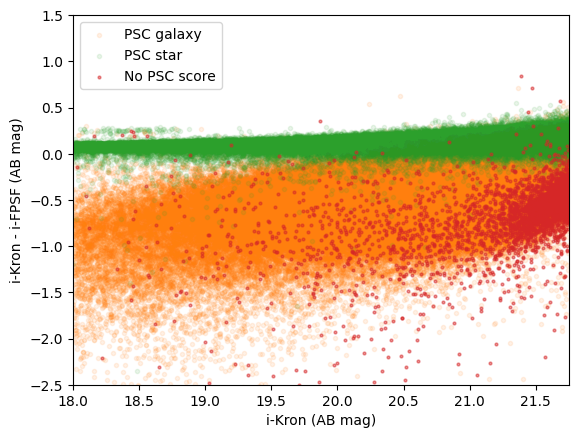

In [48]:
# %%
# plot iFKronMag vs iFKronMag - iFPSFMag to check the star/galaxy separation
fig, ax = plt.subplots()
ax.scatter(
    df_galaxy["iFKronMag"],
    df_galaxy["iFKronMag"] - df_galaxy["iFPSFMag"],
    s=3**2,
    c="C1",
    alpha=0.1,
    label="PSC galaxy",
    rasterized=True,
)
ax.scatter(
    df_star["iFKronMag"],
    df_star["iFKronMag"] - df_star["iFPSFMag"],
    s=3**2,
    c="C2",
    alpha=0.1,
    label="PSC star",
    rasterized=True,
)
ax.scatter(
    df_no_psc["iFKronMag"],
    df_no_psc["iFKronMag"] - df_no_psc["iFPSFMag"],
    s=2**2,
    c="C3",
    alpha=0.5,
    label="No PSC score",
    rasterized=True,
)
ax.set_xlabel("i-Kron (AB mag)")
ax.set_ylabel("i-Kron - i-FPSF (AB mag)")
ax.legend()
ax.set_xlim(xmin, xmax)
ax.set_ylim(-2.5, 1.5)

plt.savefig("pointsource_classification.png", dpi=300, bbox_inches="tight")
plt.show()


 ### RA and Dec difference between DR1 (from PSC) and DR2

<Figure size 640x480 with 0 Axes>

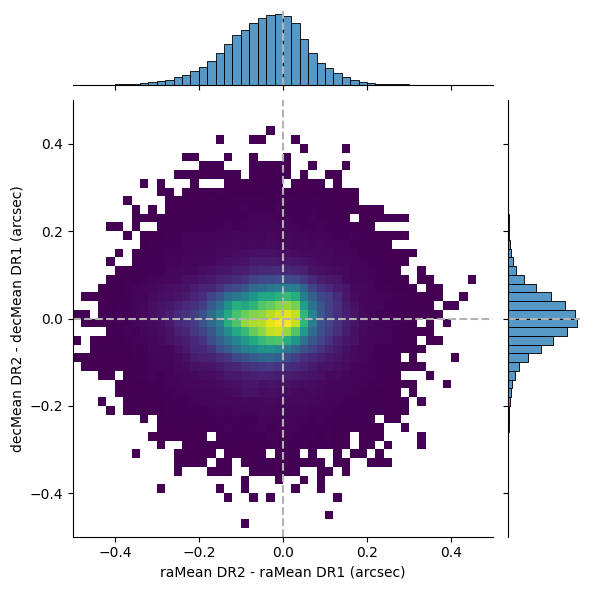

In [49]:
# %%
# plot difference in ra and dec between main and psc as a density plot to check the consistency of objIDs
fig = plt.figure()

xmin, xmax = -0.5, 0.5
ymin, ymax = -0.5, 0.5

g = sns.jointplot(
    x=(df_select["raMean"] - df_select["raMeanPSC"]) * 3600,
    y=(df_select["decMean"] - df_select["decMeanPSC"]) * 3600,
    kind="hist",
    palette="viridis",
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    dropna=True,
    joint_kws=dict(
        bins=50,
        binrange=[(xmin, xmax), (ymin, ymax)],
        thresh=5,
        cmap="viridis",
    ),
    marginal_kws=dict(
        bins=50,
        binrange=(xmin, xmax),
    ),
)

g.refline(x=0, y=0, linestyle="--", color="0.7")
g.xlim = (xmin, xmax)
g.ylim = (ymin, ymax)
g.set_axis_labels(
    "raMean DR2 - raMean DR1 (arcsec)",
    "decMean DR2 - decMean DR1 (arcsec)",
)
g.savefig("ra_dec_diff.png", dpi=300, bbox_inches="tight")


 ## Save the selected objects in a file for the PFS target uploader

 We need to prepare a target list compatible for the PFS target uploader and the target database. The target list should include the following columns: `ob_code`, `obj_id`, `ra`, `dec`, `exptime`, `priority`, `resolution`, `g_ps1`, `g_ps1_error`, `r_ps1`, `r_ps1_error`, `i_ps1`, `i_ps1_error`, `z_ps1`, `z_ps1_error`, `y_ps1`, `y_ps1_error` (see the [documentation](https://pfs-etc.naoj.hawaii.edu/uploader/doc/inputs.html) of the uploader for the details)

In [50]:
# %%
# list of output columns
out_columns = [
    "ob_code",
    "obj_id",
    "ra",
    "dec",
    "exptime",
    "priority",
    "resolution",
    "g_ps1",
    "g_ps1_error",
    "r_ps1",
    "r_ps1_error",
    "i_ps1",
    "i_ps1_error",
    "z_ps1",
    "z_ps1_error",
    "y_ps1",
    "y_ps1_error",
]


In [51]:
# %%
# rename columns to be compatible with the PFS target uploader
rename_columns = {
    "objID": "obj_id",
    "raStack": "ra",
    "decStack": "dec",
}
df_select.rename(columns=rename_columns, inplace=True)


/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/1794181458.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.rename(columns=rename_columns, inplace=True)


In [52]:
# %%
# set additional columns
df_select["exptime"] = 900  # 15 min exposure
df_select["priority"] = 1  # (optional)


/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/888549275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select["exptime"] = 900  # 15 min exposure
/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/888549275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select["priority"] = 1  # (optional)


In [53]:
# %%
# set flux columns after converting the fluxes to nJy
bands = ["g", "r", "i", "z", "y"]
for b in bands:
    df_select[f"{b}_ps1"] = df_select[f"{b}FKronFlux"] * 1e9
    df_select[f"{b}_ps1_error"] = df_select[f"{b}FKronFluxErr"] * 1e9


/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/737685611.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select[f"{b}_ps1"] = df_select[f"{b}FKronFlux"] * 1e9
/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/737685611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select[f"{b}_ps1_error"] = df_select[f"{b}FKronFluxErr"] * 1e9
/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/737685611.py:5: SettingWithCopyWarning: 
A value is trying to be set o

In [54]:
# %%
# prepare separete target lists for different resolutions
df_combined = pd.DataFrame()
for res in ["L", "M"]:
    # set resolution
    df_select["resolution"] = res

    # set ob_code by combining obj_id and resolution
    df_select["ob_code"] = (
        "ps1dr2_filler_" + df_select["obj_id"].astype(str) + "_" + res
    )

    # append to the combined DataFrame
    df_combined = pd.concat([df_combined, df_select.loc[:, out_columns]], axis=0)

    # # save in CSV, Feather, and Parquet formats
    # df_select.loc[:, out_columns].to_csv(
    #     f"ps1_filler_targetlist_{res.lower()}r.csv", index=False
    # )
    # df_select.loc[:, out_columns].to_feather(
    #     f"ps1_filler_targetlist_{res.lower()}r.feather"
    # )
    # df_select.loc[:, out_columns].to_parquet(
    #     f"ps1_filler_targetlist_{res.lower()}r.parquet"
    # )

df_combined.to_csv("ps1_filler_targetlist_combined.csv", index=False)
df_combined.to_feather("ps1_filler_targetlist_combined.feather")
df_combined.to_parquet("ps1_filler_targetlist_combined.parquet")


/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/3919546056.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select["resolution"] = res
/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/3919546056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select["ob_code"] = (
/var/folders/z7/zhnljs190hvgp0dgrynp8m8m0000gn/T/ipykernel_62216/3919546056.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

 You can use `ps_filler_targetlist_{lr,mr}.csv` files for the PFS target uploader. However, the uploader cannot accept files over ~10MB, so use the CLI tool to assign an `upload_id` to work with the target database.